<a href="https://colab.research.google.com/github/PedroABull/MVP_Split_3_PedroBull/blob/main/PedroABull_MVP_Split_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP Análise de Dados e Boas Práticas

**Nome:** Pedro Albergaria Bull

**Matrícula:** 4052024002243

**Dataset:** [Olist Dataset](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce/data)

**---OBSERVAÇÕES---**

Para esse projeto, foram usados como fontes de dados somente os arquivos:

- Dados de Produtos ("olist_products_dataset.csv")
- Dados de Clientes ("olist_customers_dataset.csv")
- Dados de Pedidos ("olist_orders_dataset.csv")
- Dados de itens de pedidos ("olist_order_items_dataset.csv")

 **------**

## Descrição do Problema e Abordagem

O conjunto de dados **Olist** é uma base rica e multivariada proveniente de um marketplace brasileiro, composta por informações detalhadas sobre pedidos online. Os dados abrangem diversas tabelas inter-relacionadas que incluem informações sobre clientes, produtos, categorias de produtos, vendedores, pagamentos, entregas, avaliações dos consumidores e dados temporais de cada etapa da jornada de compra.

O objetivo deste projeto é realizar uma **análise exploratória dos dados (EDA)** e o **pré-processamento necessário** para a construção de um modelo de **aprendizado supervisionado**. O foco será um problema de **regressão**, com o intuito de **prever o total de unidades vendidas** por categoria de produto e por região.

Para isso, utilizei os dados disponíveis nas diferentes tabelas do conjunto Olist  com o objetivo de consolidar um dataset estruturado que permitisse capturar os principais fatores que influenciam o volume de vendas.

# Considerações sobre as bases de dados

Por questões de boas práticas e organização, optei por deixar o notebook de construção da base de dados principal a parte, já que não é o objetivo do projeto demonstrar o pipeline para consolidação dos dados. Se necessário, o notebook "Construcao_base_principal.ipynb" pode ser consutado no repositório do GitHub.

## Atributos do Dataset

A base de dados `sales_db_01.csv` foi organizada de forma que **cada linha representa um produto vendido**. Isso significa que, para pedidos contendo múltiplos produtos, o **código de identificação do pedido (`order_id`) é repetido** para cada item individualmente registrado.

A base contém as seguintes colunas:

- **sale_date**: Data da venda  
- **order_id**: Código de identificação do pedido  
- **customer_id**: Código de identificação do cliente  
- **product_id**: Código de identificação do produto do pedido  
- **product_category_name**: Categoria do produto  
- **product_description_lenght**: Número de caracteres na descrição do anúncio do produto  
- **order_units**: Quantidade de unidades do produto no pedido  
- **unit_price**: Preço unitário do produto  
- **zip_code_prefix**: Prefixo do CEP do cliente  
- **customer_state**: Unidade federativa (UF) de destino do pedido


## Hipóteses do Problema

As hipóteses que tracei são as seguintes:

- A demanda geral mostra tendências temporais relevantes.

- Quanto maior a população do estado, maior o volume de vendas.

- Existe uma correlação negativa entre preço unitáiro e unidades vendidas(preços mais altos levam a menor demanda).

# Importação das Bibliotecas Necessárias e Carga de Dados

In [178]:
# Importando as bibliotecas
import pandas as pd
import seaborn as sns

# Configurando o matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import warnings

# Ignorar todos os warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [179]:
# Definindo o caminho de importação da base
path_dados = "https://raw.githubusercontent.com/PedroABull/MVP_Split_3_PedroBull/refs/heads/main/data/sales_db_01.csv"

In [180]:
# Importando a base de dados
df = pd.read_csv(path_dados)

In [181]:
# Visualizando os dados
df.head(2)

,sale_date,order_id,customer_id,product_id,product_category_name,product_description_lenght,order_units,unit_price,zip_code_prefix,customer_state
0,2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,87285b34884572647811a353c7ac498a,utilidades_domesticas,268.0,1,29.99,3149,SP
1,2018-07-24 20:41:37,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,595fac2a385ac33a80bd5114aec74eb8,perfumaria,178.0,1,118.70,47813,BA


# Data Cleaning

In [182]:
# Visualizando as informações da base de dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100196 entries, 0 to 100195
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   sale_date                   100196 non-null  object 
 1   order_id                    100196 non-null  object 
 2   customer_id                 100196 non-null  object 
 3   product_id                  100196 non-null  object 
 4   product_category_name       98795 non-null   object 
 5   product_description_lenght  98795 non-null   float64
 6   order_units                 100196 non-null  int64  
 7   unit_price                  100196 non-null  float64
 8   zip_code_prefix             100196 non-null  int64  
 9   customer_state              100196 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 7.6+ MB


Após avaliar as informações iniciais da base de dados, as seguintes ações precisam ser tomadas:

- Retirar todas as colunas de "id" da base, já que essas colunas trazem chaves únicas de identificação das variáveis, o que é irrelevante para o problema
- Retirar a coluna "zip_code_prefix" para evitar duplicidade de informações de região, já que a coluna customer_state já trás essa informação categorizada
- Transformar a coluna de data para o formato datetime
- Tratar os valores nulos na base de dados
- Agrupar os dados para maior adequação ao problema

In [183]:
# Excluindo as colunas de id
df = df.drop(["order_id", "customer_id", "product_id", "zip_code_prefix"], axis = 1)

In [184]:
# Desconsiderando o horário das datas
dates = []
for date in df['sale_date'].values:
    dates.append(date[:10])

df['sale_date'] =  dates

#  Transformando a coluna de data para datetime
df['sale_date'] = pd.to_datetime(df['sale_date'])

In [185]:
# Tratando valores nulos das colunas product_category_name e product_description_lenght
# Avaliando a porcentagem de valores nulos perdidos
faltantes = df.loc[
    (df['product_category_name'].isnull()) &
    (df['product_description_lenght'].isnull())
]

porcentagem = 100 * len(faltantes) / df.shape[0]
print('Porcentagem de dados faltantes em relação ao total de registros da base: {:.2f}%'.format(porcentagem))

Porcentagem de dados faltantes em relação ao total de registros da base: 1.40%


- Como as informações faltantes representam menos de 2% das informações totais, optei por excluir as linhas com dados nulos.

In [186]:
# Retirando as linhas nulas de product_category_name e product_description_lenght
df = df.dropna()

- Como o objetivo do projeto é prever vendas por região ao longo do tempo por categoria de produto, é necessário agrupar os dados nessas features para que cada ocorrência na base represente um ponto no espaço.

- O preço foi agrupado como média sem considerar a ponderação por unidades vendidas pois o objetivo é entender qual a média de preço dos produtos de cada categoria.

In [187]:
# Agrupando os dados
# Criando uma base de vendas por região
df = df.groupby(by=['sale_date', 'customer_state', 'product_category_name'], as_index = False).agg({'order_units' : 'sum', 'unit_price' : 'mean'})
df = df.rename(columns={'unit_price':'mean_unit_price'})

# Visualizando a base
df.head(5)

,sale_date,customer_state,product_category_name,order_units,mean_unit_price
0,2016-09-15,SP,beleza_saude,3,44.990
1,2016-10-03,GO,brinquedos,1,128.900
2,2016-10-03,MG,moveis_decoracao,1,74.900
3,2016-10-03,RS,esporte_lazer,2,29.195
4,2016-10-03,SP,fashion_calcados,1,29.990


# Análise Exploratória dos dados

In [188]:
# Visualizando as informações da base de dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54806 entries, 0 to 54805
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   sale_date              54806 non-null  datetime64[ns]
 1   customer_state         54806 non-null  object        
 2   product_category_name  54806 non-null  object        
 3   order_units            54806 non-null  int64         
 4   mean_unit_price        54806 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 2.1+ MB


## Avaliando histórico de vendas e possíveis outliers

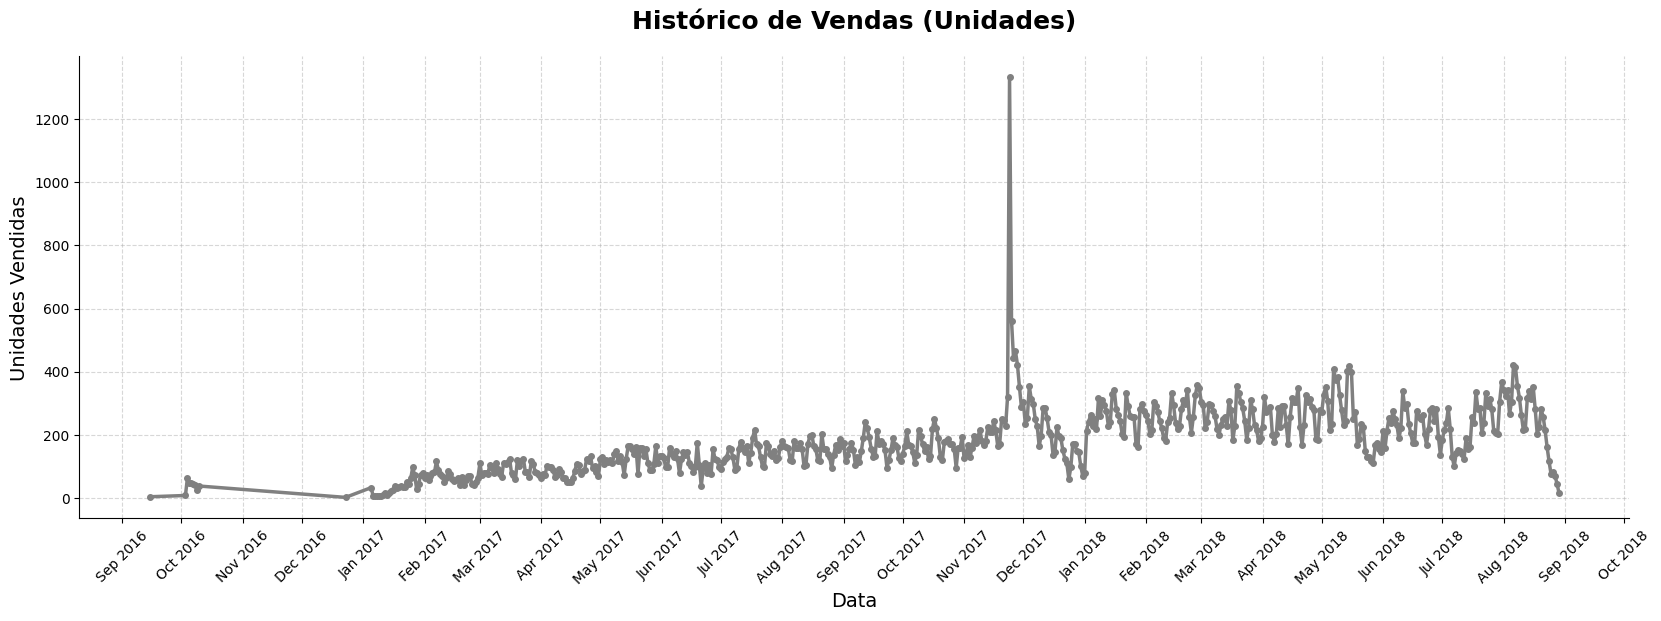

In [189]:
# Criando base para plotar vendas históricas
df_chart = df[['sale_date', 'order_units']].groupby('sale_date', as_index=False).sum()

# Criar a figura
fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(df_chart['sale_date'], df_chart['order_units'], color='gray', linewidth=2.5, marker='o', markersize=4)

# Título e eixos
ax.set_title('Histórico de Vendas (Unidades)', fontsize=18, weight='bold', pad=20)
ax.set_xlabel('Data', fontsize=14)
ax.set_ylabel('Unidades Vendidas', fontsize=14)

# Melhorar visualização de datas no eixo X
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

# Grade leve e fundo branco
ax.grid(True, linestyle='--', alpha=0.5)

# Remover borda direita e superior
sns.despine()

plt.show()

- Entre setembro de 2016 e janeiro 2017 a base apresenta inconsistências com relação a quantidade de dados disponíveis. Avaliando esse período mais especificamente, temos que somente a partir de fevereiro de 2017 os dados começam a ser mais consistentes, como mostra o gráfico abaixo. Por isso, todos os dados anteriores a fevereiro de 2017 serão excluidos da base.

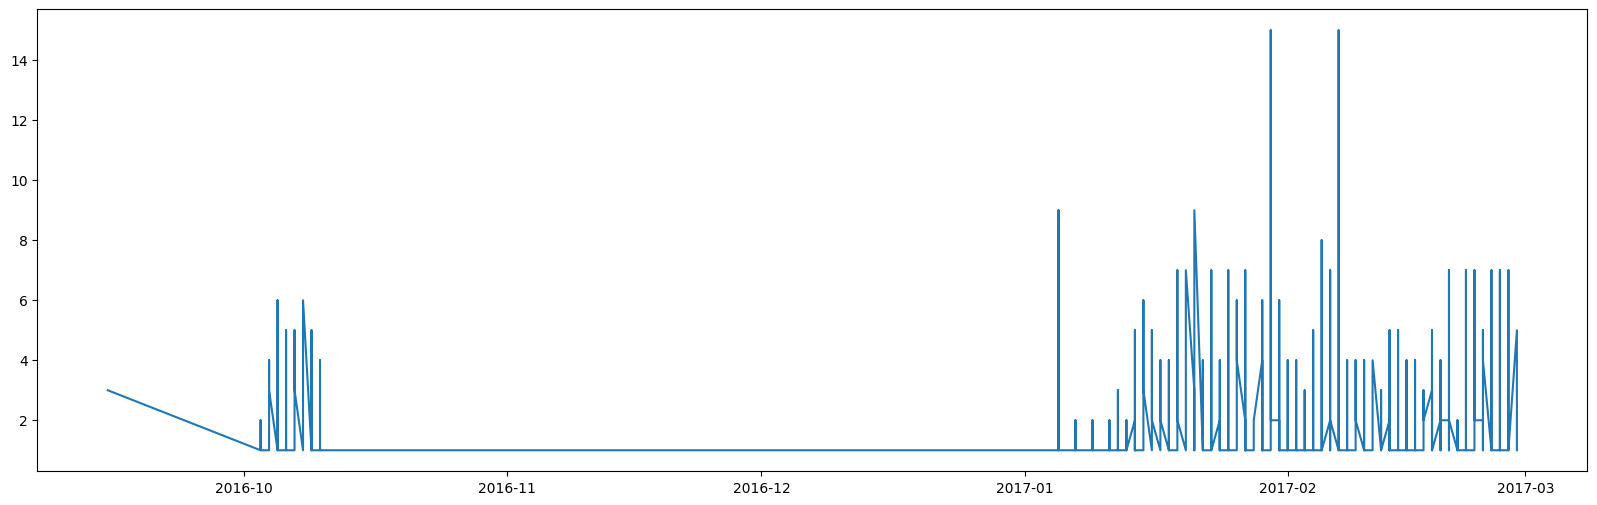

In [190]:
# Plotando resultados anteriores a fevereiro de 2017

df_val = df[df['sale_date'] < pd.to_datetime('2017-03-01')]

fig, ax = plt.subplots(figsize = (20,6))

ax.plot(df_val['sale_date'], df_val['order_units'])

plt.show()

### Avaliando Outliers

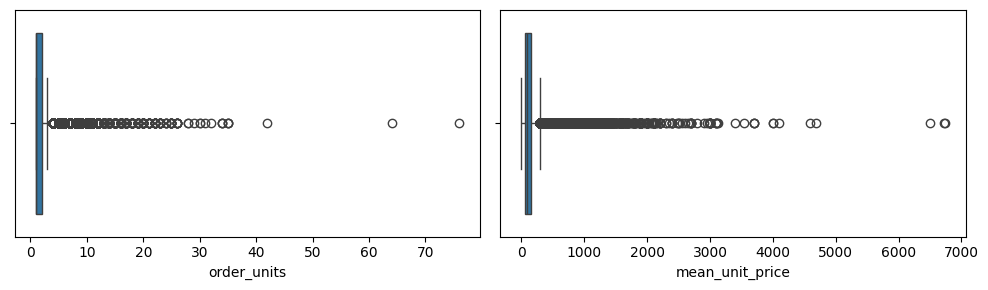

In [191]:
# Plotando os boxplots para avaliar a distribuição dos dados
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 3), tight_layout = True)

for ax, col in zip(axs, df.select_dtypes('number')):
    sns.boxplot(data = df, x = col, ax=ax)

plt.show()

In [192]:
# Avaliando o período de pico de vendas
df_chart.loc[df_chart['order_units'] > 400]

,sale_date,order_units
333,2017-11-24,1333
334,2017-11-25,561
335,2017-11-26,444
336,2017-11-27,464
337,2017-11-28,422
497,2018-05-07,409
504,2018-05-14,401
505,2018-05-15,417
588,2018-08-06,420
589,2018-08-07,413


- Os 6 maiores dias de vendas aconteceram na black fiday de 2017 (última sexta-feira do mês de novembro). Essa é uma data que se repete todo ano e, por isso, faz sentido manter esses registros, por mais que fujam muito do padrão.

- Com relação ao preço, os outliers não são registros a serem desconsiderados, pois de fato existem produtos muito mais caros que outros.

## Estatística Descritiva


In [193]:
# Visualizando a descrição estatística das colunas numéricas
with pd.option_context('display.float_format', "{:.2f}".format):
    display(df[["order_units", "mean_unit_price"]].describe())

,order_units,mean_unit_price
count,54806.00,54806.00
mean,1.98,133.32
std,2.22,196.90
min,1.00,0.85
25%,1.00,49.00
50%,1.00,86.99
75%,2.00,144.96
max,76.00,6735.00


## Análises de Correlação e Distribuição por categoria


In [194]:
# Avaliando a correlação de atributos numéricos
df[["order_units", "mean_unit_price"]].corr()

,order_units,mean_unit_price
order_units,1.000000,-0.053509
mean_unit_price,-0.053509,1.000000


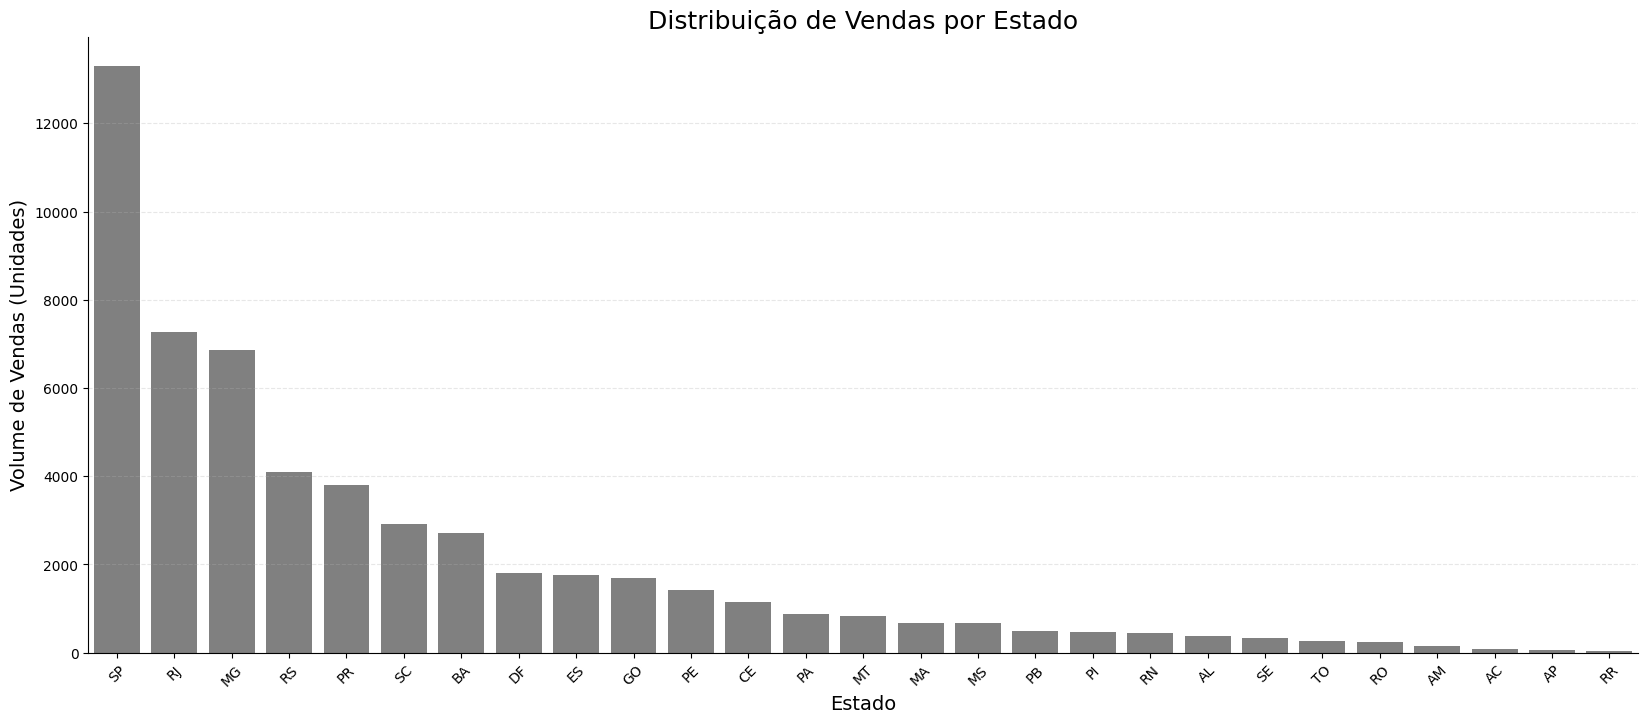

In [195]:
# Plotando vendas por estado
# Ordenar os estados pelo volume de vendas (frequência)
ordem_estados = df['customer_state'].value_counts().index

# Plotar gráfico com ordem decrescente
plt.figure(figsize=(20, 8))
sns.countplot(x='customer_state', data=df, order=ordem_estados, color = 'gray')

plt.title('Distribuição de Vendas por Estado', fontsize=18)
plt.xlabel('Estado', fontsize=14)
plt.ylabel('Volume de Vendas (Unidades)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)
sns.despine()
plt.show()

### Análise de Cardinalidade

In [196]:
# Avaliando a cardinalidade das features
print('Cardinalidade das Features:')
df.nunique()

Cardinalidade das Features:


,0
sale_date,612
customer_state,27
product_category_name,73
order_units,36
mean_unit_price,14892


In [197]:
# Avaliando a cardinalidade da coluna de categoria de produtos
df.product_category_name.value_counts()

,count
product_category_name,
beleza_saude,3795
esporte_lazer,3400
cama_mesa_banho,3392
informatica_acessorios,3103
moveis_decoracao,3043
...,...
portateis_cozinha_e_preparadores_de_alimentos,12
cds_dvds_musicais,12
pc_gamer,7


- Existem 73 categorias diferentes de produtos na base e não é adequado para carregar todas essas infromações para o modelo, já que aumentaria muito a dimensão da base de dados. Por isso, foram selecionadas as categorias que representam 70 % dos registros de venda para serem mantidas e as categorias restantes serão agrupadas em um único grupo.


# Pré-Processamento de Dados

O primeiro passo para a etapa de pré-processamento é separar o conjunto de dados entre treino e teste e, assim, aplicar as transformações. Isso evita a ocorrência de **Data Leakage** com os dados.

In [198]:
# Separar features (X) e target (y)
X = df.drop('order_units', axis=1)
y = df['order_units']

In [199]:
# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [200]:
# Avaliando a quantidade de dados em cada uma das partições da base
print(f"Dimensões de X_train: {X_train.shape}")
print(f"Dimensões de X_test: {X_test.shape}")
print(f"Dimensões de y_train: {y_train.shape}")
print(f"Dimensões de y_test: {y_test.shape}")

Dimensões de X_train: (38364, 4)
Dimensões de X_test: (16442, 4)
Dimensões de y_train: (38364,)
Dimensões de y_test: (16442,)


In [201]:
# Visualizando novamente as informações da base de dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54806 entries, 0 to 54805
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   sale_date              54806 non-null  datetime64[ns]
 1   customer_state         54806 non-null  object        
 2   product_category_name  54806 non-null  object        
 3   order_units            54806 non-null  int64         
 4   mean_unit_price        54806 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 2.1+ MB


Ainda existem duas colunas que precisam ser transformadas para valores numéricos para estarem aptas a serem usadas em um modelo de Machine Learning:

- customer_state: Siglas dos estados brasileiros
- product_category_name: Categorias de produtos

### Transformando a coluna customer_state: Codificação Frequencial

- A Codificação Frequencial consiste em em substituir a sigla do estado pela frequência relacionada à variável target. Essa abordagem é relevante quando o atributo variável é categórico e tem muitos valores distintos, mas não há uma ordem entre eles (como é o caso dos estados brasileiros). Assim, essa é uma boa opção para capturar corretamente a correlação entre a feature e a variável target.

In [202]:
# Definindo base para o cálculo de frequência
df_train = X_train.copy()
df_train['order_units'] = y_train

# Calcular a frequência de cada estado com base apenas no treino
state_freq = df_train.groupby('customer_state')['order_units'].sum() / df_train['order_units'].sum()

# Aplicar com map
X_train['state_freq'] = X_train['customer_state'].map(state_freq)
X_test['state_freq'] = X_test['customer_state'].map(state_freq)

# Preencher possíveis NaNs na base de teste com 0
X_test['state_freq'] = X_test['state_freq'].fillna(0)

# Remover a coluna original de estado
X_train = X_train.drop(columns='customer_state')
X_test = X_test.drop(columns='customer_state')

In [203]:
# Visualizando a base de dados
X_train.head(3)

,sale_date,product_category_name,mean_unit_price,state_freq
17726,2017-10-01,moveis_escritorio,211.90,0.422726
3113,2017-03-20,malas_acessorios,249.99,0.033328
118,2016-10-07,market_place,58.00,0.115294


### Transformando a coluna product_category_name: OneHotEncoder(OHE)

- OHE transforma cada categoria em uma coluna binária (0 ou 1), preservando a distinção entre categorias sem impor hierarquia falsa (como aconteceria se fossem usaados números inteiros em uma única coluna). Assim, é possível aplicar uma codificação interpretável e segura, ideal para modelos lineares, redes neurais e muitos outros algoritmos.

- Porém, como já detalhado anteriormente, existem 73 categorias de produtos diferentes na base de dados e por isso, serão selecionadas apenas as categorias que representam 70% do volume total de vendas. O restante será agrupado como categoria de "Outros"

In [204]:
# Avaliando quantas categorias representam 70% das vendas
categories = list(df.product_category_name.value_counts().index)
j = 0     # Inicializando contadores
cat_70_perc = []        # Lista para armazenar as categorias

# Criando lista com as categorias que representam 80% dos registros de venda e quantos registros de venda cada uma tem
for cat in categories:
    if j <= 0.7:
        j = j + (df.loc[df['product_category_name'] == cat, 'product_category_name'].count()/df.shape[0])
        cat_70_perc.append([cat, int(df.loc[df['product_category_name'] == cat, 'product_category_name'].count())])
        min_freq = int(df.loc[df['product_category_name'] == cat, 'product_category_name'].count())          # Armazenando a fequência da categoria com menos registros dentro das categorias que representam 80%
    else:
        pass

In [205]:
# Visualizando a lista de categorias
cat_70_perc

[['beleza_saude', 3795],
 ['esporte_lazer', 3400],
 ['cama_mesa_banho', 3392],
 ['informatica_acessorios', 3103],
 ['moveis_decoracao', 3043],
 ['relogios_presentes', 2882],
 ['utilidades_domesticas', 2675],
 ['telefonia', 2588],
 ['cool_stuff', 2305],
 ['brinquedos', 2241],
 ['automotivo', 2227],
 ['ferramentas_jardim', 2143],
 ['perfumaria', 1918],
 ['bebes', 1855],
 ['eletronicos', 1653]]

In [206]:
# Aplicando o OHE na base de treino
ohe = OneHotEncoder(handle_unknown='ignore', min_frequency=min_freq)
ohe.fit(X_train[['product_category_name']])

OneHotEncoder(handle_unknown='ignore', min_frequency=1653)

In [207]:
# Convertendo o resultado para dataframe
X_train_ohe = pd.DataFrame(ohe.transform(X_train[['product_category_name']]).toarray(), columns=ohe.get_feature_names_out(), index=X_train.index)
X_test_ohe = pd.DataFrame(ohe.transform(X_test[['product_category_name']]).toarray(), columns=ohe.get_feature_names_out(), index=X_test.index)

In [208]:
# Unificando os dados
X_train = pd.concat([X_train.drop(columns='product_category_name'), X_train_ohe], axis=1)
X_test = pd.concat([X_test.drop(columns='product_category_name'), X_test_ohe], axis=1)

In [209]:
# Visualizando os dados de teste
X_train.head()

,sale_date,mean_unit_price,state_freq,product_category_name_beleza_saude,product_category_name_cama_mesa_banho,product_category_name_esporte_lazer,product_category_name_informatica_acessorios,product_category_name_moveis_decoracao,product_category_name_relogios_presentes,product_category_name_telefonia,product_category_name_utilidades_domesticas,product_category_name_infrequent_sklearn
17726,2017-10-01,211.90,0.422726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3113,2017-03-20,249.99,0.033328,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
118,2016-10-07,58.00,0.115294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17005,2017-09-23,13.90,0.003603,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14505,2017-08-25,49.90,0.037248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


- Assim, foi construida uma base de dados adequada para a aplicação detalhada na definição do problema proposto.

# Conclusão

O projeto de análise e pré-processamento do dataset Olist aplicou boas práticas na estruturação e preparação dos dados para um problema de aprendizado supervisionado com foco em regressão. A base foi consolidada a partir de diferentes fontes (pedidos, produtos, clientes e itens dos pedidos), permitindo a construção de uma visão integrada das vendas ao longo do tempo.

A etapa de análise exploratória revelou padrões relevantes, como a concentração das vendas em algumas categorias e regiões específicas, além da identificação de comportamentos sazonais. Foram aplicadas transformações adequadas às variáveis categóricas, como One-Hot Encoding para product_category_name (após a redução da cardinalidade) e Codificação Frequencial para customer_state, assegurando a compatibilidade com os algoritmos de machine learning.

Além disso, os dados foram agregados em uma estrutura temporal, o que viabilizou a modelagem da demanda diária por produto, categoria ou região. O cuidado com o tratamento de dados faltantes, a prevenção de vazamento de dados e a separação adequada entre treino e teste contribuíram para um tratamento de dados robusto e generalizável.

Em resumo, a preparação dos dados garantiu uma base sólida para a construção de modelos preditivos capazes de estimar o volume de vendas com boa acurácia, atendendo aos objetivos do negócio com foco em planejamento de demanda e tomada de decisão estratégica.

Abaixo segue a avaliação das 3 hipóteses estabelecidas no início do projeto:

1.   *A demanda geral mostra tendências temporais relevantes?* Sim, o gráfico de análise temporal mostra alguns padrões de sazonalidade, sendo o mais relevante o que acontece durante o perído de *Black Friday*, próximo a última sexta-feira dos meses de novembro.

2.   *Quanto maior a população do estado, maior o volume de vendas?* Em linhas gerais, essa hipótese é verdadeira. Os estados mais populosos ocupam as primeiras posições no ranking de compras, mas a seuquência não segue exatamente a regra de população. Minas Gerais, por exemplo, que é o segundo estado mais populoso do país está na terceira colocação no ranking de volume de vendas, enquanto o Rio de Janeiro, com 5 millhoes a menos de habitantes(Fonte:IBGE) ocupa a segunda colocação.

3.   *Existe uma correlação negativa entre preço unitário e unidades vendidas (preços mais altos levam a menor demanda)?* Existe uma correlação levemente negativa, mas pode-se considerar que não existe influência direta entre preço e demanda dos itens, ou seja, não necessáriamente um item mais barato terá um maior volume de vendas do que um item mais caro.